In [223]:
import numpy as np
import matplotlib.pyplot as plt

class image_unit:
    def __init__(self) -> None:
        self.num_of_points = 0
        self.cord_of_points = np.array([])
        self.raw_image = np.array([])
    def print_data(self) -> None:
        print(self.num_of_points)
        print(self.cord_of_points)
        print(self.raw_image)
        # Plotting the array as a grayscale image
        plt.imshow(self.raw_image, cmap='viridis')
        plt.colorbar()  # Adding a colorbar to show intensity scale
        plt.title('Visualization')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

100
No. 1
<class 'numpy.float64'>
10
[[ 4.40713266 27.53953829]
 [32.34440351 13.07851211]
 [52.47361097 12.67095481]
 [ 5.58836544  7.56791729]
 [15.93699632  9.79119369]
 [51.17877819 58.85360808]
 [30.06994402 52.20290573]
 [19.65551056 47.53884791]
 [40.81064392  6.9202662 ]
 [22.1720807  19.41307516]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


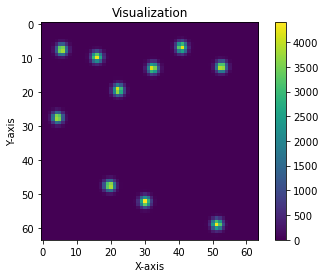

In [224]:
# Specify the path to your text file
file_path = './Clusters_2D_100.txt'
images = []

# For every image:
# Line 1: number of points(10)
# Line 2-11: exact positions of the points
# Others: grayscale image
with open(file_path, 'r') as file:
    cop = [] # Store cordinates of points tempoarily
    ri = [] # Store raw image tempoarily
    for line in file:
        numbers = []
        numbers = [float(s) for s in line.strip().split()]
        if len(numbers) == 1:
            if len(images) > 0:
                images[-1].raw_image = np.array(ri).T
                ri.clear()
            images.append(image_unit())
            images[-1].num_of_points = int(numbers[0])
        elif len(numbers) == 2:
            cop.append(numbers)
            if len(cop) == images[-1].num_of_points:
                images[-1].cord_of_points = np.array(cop)
                images[-1].cord_of_points = images[-1].cord_of_points - 0.5 # -0.5, now the center is at (0, 0)
                cop.clear()
        else:
            ri.append(numbers)
    images[-1].raw_image = np.array(ri).T

print(len(images))

# Print the list of numbers
for i in range(1):
    print('No.', i + 1)
    print(type(images[i].raw_image[0][0]))
    images[i].print_data()

In [225]:
def find_local_maxima(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    def is_local_maxima(i, j):
        current = matrix[i][j]
        # Check all eight possible neighbors
        neighbors = [
            (i-1, j-1), (i-1, j), (i-1, j+1),
            (i, j-1),            (i, j+1),
            (i+1, j-1), (i+1, j), (i+1, j+1)
        ]
        for x, y in neighbors:
            if 0 <= x < rows and 0 <= y < cols:
                if matrix[x][y] >= current:
                    return False
        return True

    local_maxima = []
    for i in range(rows):
        for j in range(cols):
            if is_local_maxima(i, j):
                local_maxima.append((j, i))
    
    return local_maxima

# Find the local maximum
local_maxima = find_local_maxima(images[0].raw_image)


print("Local Maxima:", local_maxima) # 局部最大值的位置

Local Maxima: [(41, 7), (6, 8), (16, 10), (32, 13), (52, 13), (22, 19), (4, 28), (20, 48), (30, 52), (51, 59)]


In [226]:
import cv2

# Define the color (B, G, R) and thickness of the cross marks
# color = (0, 255, 0)  # Green color
# cross_length = 10  # Length of the cross arms
# thickness = 2  # Thickness of the lines
def mark_point(image: np.array, points: list, color = (0, 255, 0), type = 'normal', cross_length = 2, thickness = 1) -> np.array:
    # Ensure the image is a NumPy array with the correct dtype
    if image.dtype != np.uint8:
        marked_image = (image / np.max(image) * 255).astype(np.uint8)
    else:
        marked_image = np.copy(image)
    if len(marked_image.shape) == 2 or (len(marked_image.shape) == 3 and marked_image.shape[2] == 1):
        marked_image = cv2.applyColorMap(marked_image, cv2.COLORMAP_TWILIGHT_SHIFTED)
    if type == 'normal':
        for (x, y) in points:
            cv2.line(marked_image, (x - cross_length, y), (x + cross_length, y), color, thickness)
            cv2.line(marked_image, (x, y - cross_length), (x, y + cross_length), color, thickness)
    elif type == 'skew':
        for (x, y) in points:
            cv2.line(marked_image, (x - cross_length, y - cross_length), (x + cross_length, y + cross_length), color, thickness)
            cv2.line(marked_image, (x + cross_length, y - cross_length), (x - cross_length, y + cross_length), color, thickness)
    # Display the image with marked points
    return marked_image

In [227]:
def extract_subarray(array, center, half_size = 2): # A 5x5 array by default, half_size is 2
    """
    Extract a 5x5 subarray centered around the specified data point (center_x, center_y).
    
    Parameters:
    array (numpy.ndarray): The input array from which to extract the subarray.
    center_x (int): The x-coordinate (row) of the center data point.
    center_y (int): The y-coordinate (column) of the center data point.
    
    Returns:
    numpy.ndarray: The extracted 5x5 subarray, or None if the center point is too close to the border.
    """
    (center_x, center_y) = center
    # Ensure the center is not too close to the borders
    left = max(center_x - half_size, 0)
    right = min(center_x + half_size + 1, array.shape[0])
    down = max(center_y - half_size, 0)
    up = min(center_y + half_size + 1, array.shape[1])
    # Extract the 5x5 subarray centered around (center_x, center_y)
    subarray = array[down : up,
                     left : right]
    return subarray

[(4.40713265801572, 27.539538291703874), (32.34440350822294, 13.078512105334035), (52.473610967129076, 12.670954812016848), (5.588365442640924, 7.567917290512826), (15.936996322861567, 9.791193687624183), (51.17877819316273, 58.85360808253424), (30.06994401674475, 52.202905728831574), (19.65551056223808, 47.538847909050986), (40.81064392120531, 6.920266202730436), (22.17208069830488, 19.413075159064046)]


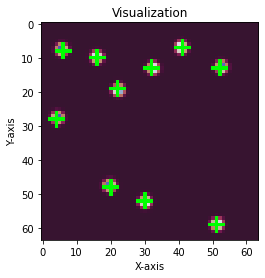

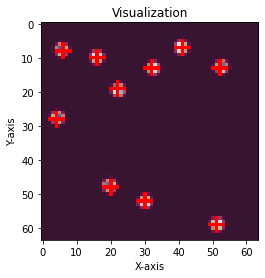

Test [1 1 2 2 2]
[ 4.40713266 27.53953829]
[ 4 28]
[[ 104.  589. 1401. 1266.  448.]
 [ 255. 1534. 3533. 3274. 1196.]
 [ 273. 1618. 3744. 3474. 1174.]
 [ 101.  662. 1562. 1357.  515.]
 [  17.  108.  269.  238.   86.]]
[32.34440351 13.07851211]
[32 13]
[[  57.  258.  558.  519.  170.]
 [ 163. 1143. 2440. 2076.  762.]
 [ 333. 1930. 4175. 3497. 1283.]
 [ 239. 1284. 2863. 2384.  848.]
 [  64.  351.  799.  633.  240.]]
[52.47361097 12.67095481]
[52 13]
[[  65.  468. 1024. 1083.  406.]
 [ 218. 1349. 3161. 3165. 1180.]
 [ 228. 1633. 3843. 3681. 1372.]
 [ 118.  683. 1755. 1749.  656.]
 [  19.  158.  316.  321.  125.]]
[5.58836544 7.56791729]
[6 8]
[[ 401. 1216. 1286.  547.  104.]
 [1178. 3275. 3497. 1493.  281.]
 [1240. 3425. 3749. 1602.  296.]
 [ 548. 1505. 1609.  672.  114.]
 [ 105.  216.  268.  107.   20.]]
[15.93699632  9.79119369]
[16 10]
[[ 210.  677.  976.  596.  146.]
 [ 620. 2285. 3235. 1908.  495.]
 [ 759. 2961. 4311. 2596.  585.]
 [ 406. 1447. 2109. 1352.  307.]
 [  84.  328.  463.  

In [228]:
print([tuple(row) for row in images[0].cord_of_points])
marked_test = mark_point(images[0].raw_image, find_local_maxima(images[0].raw_image))
plt.imshow(marked_test)
plt.title('Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
marked_test = mark_point(marked_test, [tuple(row) for row in np.round(images[0].cord_of_points).astype(int)], (255, 0, 0))
plt.imshow(marked_test)
plt.title('Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

arr_test = [1.0, 1.3, 1.6, 1.9, 2.2]
print('Test', np.round(arr_test).astype(int))

for i in range(len(images[0].cord_of_points)):
    print(images[0].cord_of_points[i])
    print(np.round(images[0].cord_of_points[i]).astype(int))
    print(extract_subarray(images[0].raw_image, np.round(images[0].cord_of_points[i]).astype(int)))

[[0.1893560787946882, 0.0797337972695642, 0.20545851893636372], [0.4116345573590756, 0.4320827094871742, 0.5967733880209304], [0.06300367713843258, 0.20880631237581682, 0.21810442320354495], [-0.3444035082229391, -0.07851210533403474, 0.3532391925597309], [-0.47361096712907624, 0.3290451879831515, 0.5766958331042513], [-0.1720806983048817, -0.41307515906404646, 0.4474850318892052], [-0.40713265801571996, 0.4604617082961262, 0.6146397205110746], [0.34448943776191854, 0.4611520909490139, 0.5756163858996461], [-0.06994401674474915, -0.2029057288315741, 0.21462269281476742], [-0.17877819316272792, 0.1463919174657633, 0.2310676001732664], [-0.18002213279462254, -0.21590269548714502, 0.28110841718906177], [-0.4353136686999477, -0.44115362604192576, 0.6197697249196246], [-0.3226695302642071, -0.12084235537823318, 0.3445555116585472], [0.16115471348444999, -0.4376472237681348, 0.46637531468787136], [-0.21138290723709474, -0.2880457029255865, 0.35728568463612065], [0.016330146000221646, -0.1024

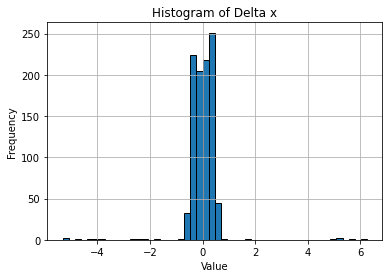

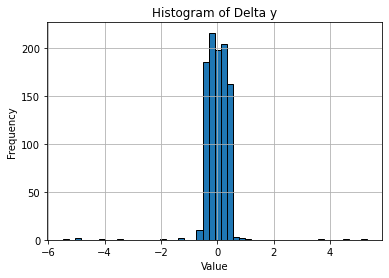

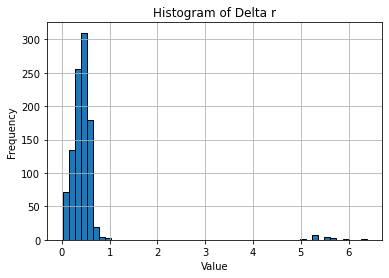

In [229]:
import math
def distance(p, q):
    # Function to calculate Euclidean distance between points p and q
    return math.sqrt((q[0] - p[0])**2 + (q[1] - p[1])**2)

def smallest_distance_to_set(point, point_set):
    # point is a tuple (x, y) representing the point P
    # point_set is a list of tuples [(x1, y1), (x2, y2), ...] representing the set S
    
    if not point_set:
        return float('inf')  # If point_set is empty, return infinity
    
    x_distance = float('inf')
    y_distance = float('inf')
    min_distance = float('inf')
    
    for q in point_set:
        dist = distance(point, q)
        if dist < min_distance:
            min_distance = dist
            x_distance = point[0] - q[0]
            y_distance = point[1] - q[1]
    
    return [x_distance, y_distance, min_distance]

dist = []
rev_dist = []
large_error = []
large_error_points = []
not_found = []
not_found_points = []

for i in range (len(images)):
    finded = find_local_maxima(images[i].raw_image)
    for j in range(len(finded)):
        dist.append(smallest_distance_to_set(finded[j], [tuple(row) for row in images[i].cord_of_points]))
        if dist[-1][2] > 1.5:
            large_error.append(i)
            large_error_points.append(finded[j])
    for j in range(len(images[i].cord_of_points)):
        rev_dist.append(smallest_distance_to_set(images[i].cord_of_points[j], finded))
        if rev_dist[-1][2] > 1.5:
            not_found.append(i)
            not_found_points.append(tuple(np.round(images[i].cord_of_points[j]).astype(int)))


print(dist)
dist_array = np.array(dist).T   
print(dist_array.shape)
print(dist_array)
print(large_error)
print(large_error_points)
print(not_found)
print(not_found_points)

# Plotting the histogram
plt.hist(dist_array[0], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta x')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(dist_array[1], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(dist_array[2], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta r')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

[7, 18, 20, 21, 33, 53, 56, 61, 74, 78, 81, 84, 86, 86, 91, 94]
[(2, 53), (54, 49), (53, 35), (30, 3), (22, 52), (35, 51), (45, 34), (19, 50), (53, 48), (55, 24), (59, 14), (28, 8), (32, 20), (31, 53), (44, 29), (47, 6)]
Image 7 Raw Data
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.  12.]
 [  0.   0.   0.  18. 143.]]


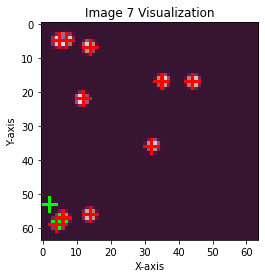

Image 18 Raw Data
[[ 91.  11.   0.   0.  39.]
 [ 12.   0.   0.   0.  13.]
 [  1.   0.   1.   0.   1.]
 [  0.   0.   0.   0.  13.]
 [  0.   0.   0.   8. 153.]]


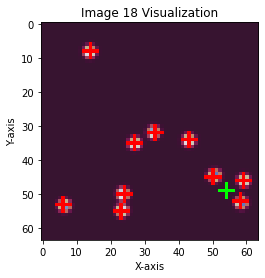

Image 20 Raw Data
[[1. 0. 0. 0. 0.]
 [9. 0. 0. 0. 0.]
 [4. 0. 1. 0. 0.]
 [2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


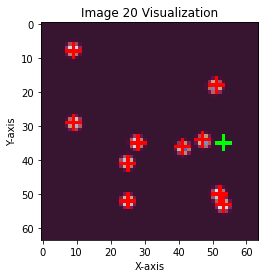

Image 21 Raw Data
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  2.  4. 19.]]


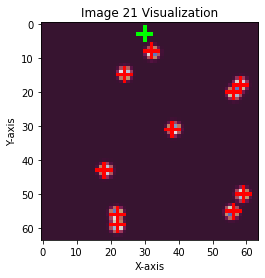

Image 33 Raw Data
[[36. 19.  4.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


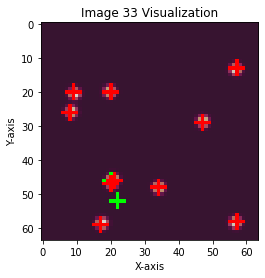

Image 53 Raw Data
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  3.]
 [ 0.  0. 15. 50. 61.]]


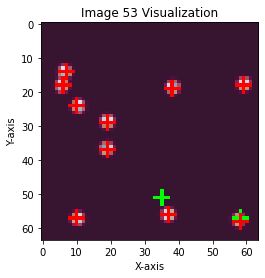

Image 56 Raw Data
[[26.  2.  0.  0.  0.]
 [48.  0.  0.  0.  0.]
 [23.  0.  1.  0.  0.]
 [ 6.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


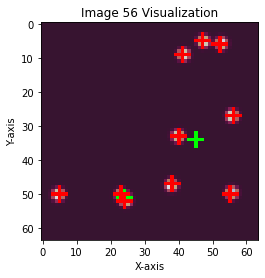

Image 61 Raw Data
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  2.]
 [ 0.  0.  3. 32. 51.]]


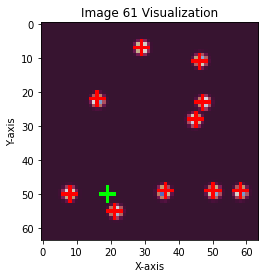

Image 74 Raw Data
[[  0.   1.  12.  55. 140.]
 [  0.   0.   0.   0.   4.]
 [  0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


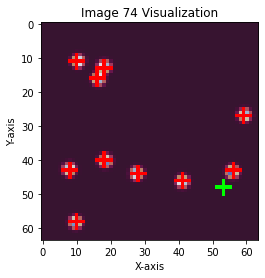

Image 78 Raw Data
[[  0.   0.   0.  17. 125.]
 [  0.   0.   0.   0.  17.]
 [  0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


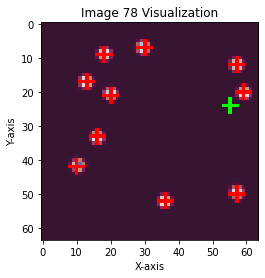

Image 81 Raw Data
[[ 2.  0.  0.  0.  0.]
 [18.  0.  0.  0.  0.]
 [57.  0.  1.  0.  0.]
 [63.  0.  0.  0.  0.]
 [27.  2.  0.  0.  0.]]


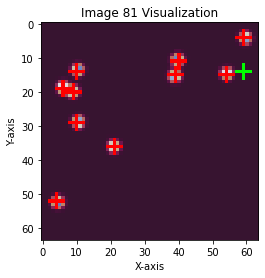

Image 84 Raw Data
[[ 0.  0.  0.  0. 10.]
 [ 0.  0.  0.  0. 27.]
 [ 0.  0.  1.  0. 17.]
 [ 0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  0.]]


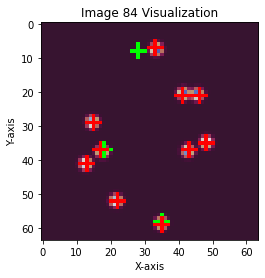

Image 86 Raw Data
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.]
 [ 0.  0.  1.  0. 10.]
 [ 0.  0.  0.  0. 44.]
 [ 0.  0.  0.  3. 38.]]


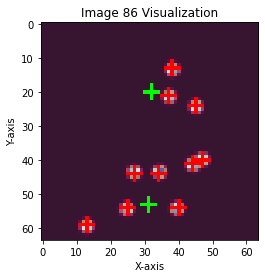

Image 86 Raw Data
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]]


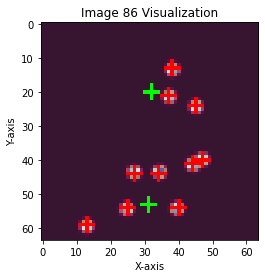

Image 91 Raw Data
[[17.  1.  0.  0.  0.]
 [33.  0.  0.  0.  0.]
 [26.  0.  1.  0.  0.]
 [ 6.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


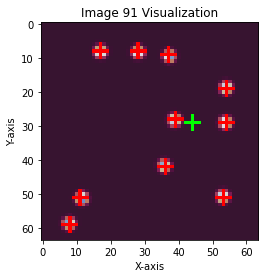

Image 94 Raw Data
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.]
 [  0.   0.   1.   0.  11.]
 [  0.   0.   0.   0.  84.]
 [  0.   0.   0.   6. 103.]]


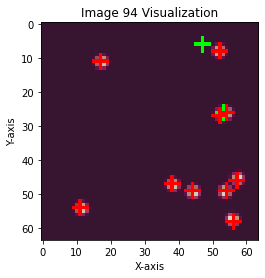

Image 7 Raw Data
Not Found: (7, 5)
[[ 854. 1175. 1254.  704.  192.]
 [3397. 3693. 3790. 2230.  533.]
 [4932. 4867. 4561. 2644.  638.]
 [2857. 2550. 2253. 1212.  288.]
 [ 683.  514.  428.  215.   53.]]


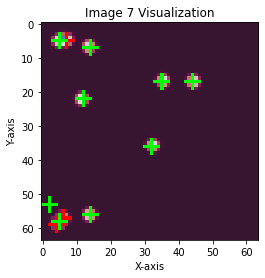

Image 22 Raw Data
Not Found: (25, 22)
[[ 145.  355.  373.  154.   40.]
 [ 746. 1853. 1970.  803.  138.]
 [1456. 3917. 4116. 1903.  352.]
 [1257. 3667. 4630. 2576.  693.]
 [ 647. 2518. 4650. 3839. 1221.]]


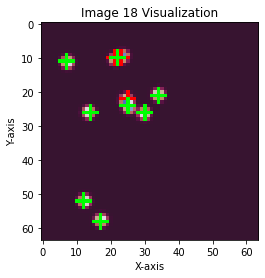

Image 34 Raw Data
Not Found: (30, 27)
[[2214. 4343. 3267.  973.  116.]
 [1717. 4065. 3814. 1460.  240.]
 [1516. 3859. 3878. 1605.  306.]
 [ 692. 1756. 1880.  776.  121.]
 [ 131.  362.  372.  133.   26.]]


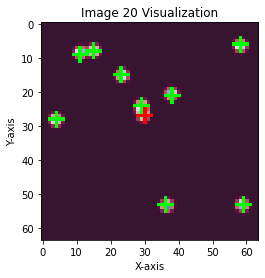

Image 49 Raw Data
Not Found: (48, 17)
[[  31.  192.  444.  380.  122.]
 [ 227.  959. 2078. 1782.  676.]
 [ 964. 2443. 4249. 3563. 1311.]
 [2707. 4111. 4405. 3066. 1039.]
 [3834. 4533. 2725. 1185.  331.]]


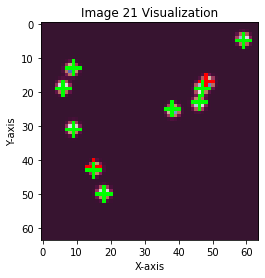

Image 67 Raw Data
Not Found: (14, 34)
[[  74.  496. 1850. 3686. 3273.]
 [ 352. 1519. 3664. 5035. 3877.]
 [ 672. 2728. 4968. 4347. 2319.]
 [ 569. 2140. 3506. 2404.  822.]
 [ 154.  710. 1154.  750.  215.]]


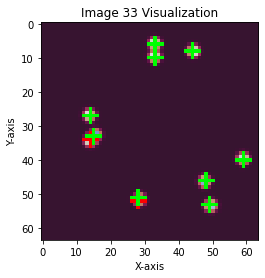

Image 93 Raw Data
Not Found: (44, 16)
[[  22.  124.  298.  382.  486.]
 [ 135.  801. 1775. 2048. 2318.]
 [ 298. 1718. 4046. 4520. 4619.]
 [ 274. 1635. 3709. 3953. 3706.]
 [  92.  576. 1285. 1462. 1207.]]


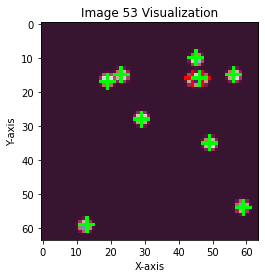

Image 97 Raw Data
Not Found: (31, 18)
[[  55.  239.  440.  306.  111.]
 [ 277. 1176. 2217. 1682.  545.]
 [ 942. 2867. 4619. 3420. 1039.]
 [2219. 4498. 4902. 3019.  828.]
 [2866. 4912. 3744. 1445.  293.]]


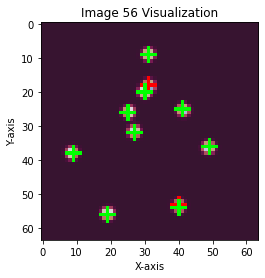

In [230]:
print(large_error)
print(large_error_points)

for i in range (len(large_error)):
    print('Image ' + str(large_error[i]) + ' Raw Data')
    # finded_list = find_local_maxima(images[large_error[i]].raw_image)
    # for j in range(len(finded_list)):
    #     print(extract_subarray(images[large_error[i]].raw_image, finded_list[j]))
    print(extract_subarray(images[large_error[i]].raw_image, large_error_points[i]))
    marked_imag = mark_point(images[large_error[i]].raw_image, find_local_maxima(images[large_error[i]].raw_image))
    marked_imag = mark_point(marked_imag, [tuple(row) for row in np.round(images[large_error[i]].cord_of_points).astype(int)], (255, 0, 0))
    plt.imshow(marked_imag)
    plt.title('Image ' + str(large_error[i]) + ' Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

for i in range (len(not_found)):
    print('Image ' + str(not_found[i]) + ' Raw Data')
    print('Not Found:', not_found_points[i])
    print(extract_subarray(images[not_found[i]].raw_image, not_found_points[i]))
    marked_imag = mark_point(images[not_found[i]].raw_image, [tuple(row) for row in np.round(images[not_found[i]].cord_of_points).astype(int)], (255, 0, 0))
    marked_imag = mark_point(marked_imag, find_local_maxima(images[not_found[i]].raw_image))

    plt.imshow(marked_imag)
    plt.title('Image ' + str(large_error[i]) + ' Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()